In [8]:
import pandas as pd
import psycopg2
import os
from dotenv import load_dotenv
from tqdm import tqdm

In [9]:
load_dotenv()
DATABASE_URL = os.environ.get('DATABASE_URL')
assert DATABASE_URL is not None, 'Missing DATABASE_URL environment variable to connect to the database'
# connect to db
conn = psycopg2.connect(DATABASE_URL)

# Open a cursor to perform database operations
cur = conn.cursor()

In [3]:
cfde_genesets = pd.read_csv("CFDE Genesets.tsv", sep='\t')
cfde_genesets

,DCC,Library,Link,Hypothesis template
0,Glygen,Glygen Glycosylated Proteins,https://cfde-drc.s3.amazonaws.com/GlyGen/XMT/2...,NaN
1,GTEx,GTEx Tissue-Specific Aging Signatures,https://cfde-drc.s3.amazonaws.com/GTEx/XMT/202...,NaN
2,GTEx,GTEx Tissue Gene Expression Profiles,https://cfde-drc.s3.amazonaws.com/GTEx/XMT/202...,NaN
3,IDG,IDG Drug Targets,https://cfde-drc.s3.amazonaws.com/IDG/XMT/2022...,NaN
4,KOMP2,KOMP2 Mouse Phenotypes,https://cfde-drc.s3.amazonaws.com/KOMP2/XMT/20...,NaN
5,LINCS,LINCS L1000 CMAP Chemical Pertubation Consensu...,https://cfde-drc.s3.amazonaws.com/LINCS/XMT/20...,NaN
6,LINCS,LINCS L1000 CMAP CRISPR Knockout Consensus Sig...,https://cfde-drc.s3.amazonaws.com/LINCS/XMT/20...,NaN
7,MoTrPAC,MoTrPAC Rat Endurance Exercise Training,https://cfde-drc.s3.amazonaws.com/MoTrPAC/XMT/...,NaN
8,Metabolomics,Metabolomics Gene-Metabolite Associations,https://cfde-drc.s3.amazonaws.com/MW/XMT/2022-...,NaN


In [5]:
import urllib.request

GlyGen_Glycosylated_Proteins = pd.DataFrame([], columns=['Library', 'Geneset', 'Genes'])
GTEx_Aging_Sigs  = pd.DataFrame([], columns=['Library', 'Geneset', 'Genes'])
GTEx_Tissues  = pd.DataFrame([], columns=['Library', 'Geneset', 'Genes'])
IDG_Drug_Targets= pd.DataFrame([], columns=['Library', 'Geneset', 'Genes'])
KOMP2_Mouse_Phenotypes = pd.DataFrame([], columns=['Library', 'Geneset', 'Genes'])
LINCS_L1000_Chem_Pert_Consensus_Sigs = pd.DataFrame([], columns=['Library', 'Geneset', 'Genes'])
LINCS_L1000_CRISPR_KO_Consensus_Sigs = pd.DataFrame([], columns=['Library', 'Geneset', 'Genes'])
MoTrPAC = pd.DataFrame([], columns=['Library', 'Geneset', 'Genes'])
Metabolomics_Workbench_Metabolites  = pd.DataFrame([], columns=['Library', 'Geneset', 'Genes'])

dataframe_list = [GlyGen_Glycosylated_Proteins, 
 GTEx_Aging_Sigs, 
 GTEx_Tissues, 
 IDG_Drug_Targets, 
 KOMP2_Mouse_Phenotypes, 
 LINCS_L1000_Chem_Pert_Consensus_Sigs, 
 LINCS_L1000_CRISPR_KO_Consensus_Sigs,
 MoTrPAC, 
 Metabolomics_Workbench_Metabolites]

# for each line, open with file link and populate database
for index, row in cfde_genesets.iterrows():
    data = []
    with urllib.request.urlopen(row['Link']) as f:
        html = f.read().decode('utf-8') 
        for line in tqdm(html.split('\n'), total=len(html.split('\n'))):
            line_content = line.split('\t')
            geneset_name =  line_content[0]
            genes = line_content[1:]
            genes = [i for i in genes if i != '']
            if len(genes) > 0:
                data.append([row['Library '], geneset_name, genes])
    dataframe_list[index] =  pd.DataFrame(data, columns=['Library', 'Geneset', 'Genes'])
        

    

100%|██████████| 234/234 [00:00<00:00, 144439.61it/s]


In [6]:
GlyGen_Glycosylated_Proteins = dataframe_list[0]
GTEx_Aging_Sigs  = dataframe_list[1]
GTEx_Tissues  = dataframe_list[2]
IDG_Drug_Targets= dataframe_list[3]
KOMP2_Mouse_Phenotypes = dataframe_list[4]
LINCS_L1000_Chem_Pert_Consensus_Sigs = dataframe_list[5]
LINCS_L1000_CRISPR_KO_Consensus_Sigs = dataframe_list[6]
MoTrPAC = dataframe_list[7]
Metabolomics_Workbench_Metabolites  = dataframe_list[8]

In [ ]:
# read in all genes and convert to dataframe
ingested_genes = pd.read_sql("SELECT * from genes", conn)

In [7]:
# Call enrichment results and return a plot and dataframe for Scatter Plot
def get_values(obj_list):
    pvals = []
    odds_ratio = []
    n_overlap = []
    overlap = []
    geneset_name = []
    for i in obj_list:
        geneset_name.append(i[0])
        pvals.append(i[1].pvalue)
        odds_ratio.append(i[1].odds_ratio)
        n_overlap.append(i[1].n_overlap)
        overlap.append(list(i[1].overlap))
    return geneset_name, pvals, odds_ratio, n_overlap, overlap


In [44]:
from maayanlab_bioinformatics.enrichment.crisp import enrich_crisp

def cross_GMTs(dataframe1, dataframe2, df_1_name, df_2_name):
    all_pvals = []
    all_odds_ratio = []
    all_n_overlap = []
    all_overlap = []
    all_geneset1 = []
    all_geneset2= []
    for index, row in tqdm(dataframe1.iterrows(), total=dataframe1.shape[0]):
        crossSets = {}
        for index_inner, row_inner in dataframe2.iterrows():
            set1 = row['Genes']
            crossSets[row_inner['Geneset']] = row_inner['Genes']
        result = sorted(filter(lambda x: x[1].pvalue < 0.05, enrich_crisp(set1, crossSets, 21000, True)), key=lambda r: r[1].pvalue)
        geneset_name, pvals, odds_ratio, n_overlap, overlap = get_values(result)
        all_geneset1.append([row['Geneset']] * len(pvals))
        all_geneset2.append(geneset_name)
        all_odds_ratio.append(odds_ratio)
        all_pvals.append(pvals)
        all_n_overlap.append(n_overlap)
        all_overlap.append(overlap)
    cross_pairs_df_data = pd.DataFrame({'Lib1': [df_1_name] * len(sum(all_geneset1, [])), 'Lib2': [df_2_name] * len(sum(all_geneset1, [])), 'Geneset_1': sum(all_geneset1, []), 'Geneset_2': sum(all_geneset2, []), 'Odds_Ratio': sum(all_odds_ratio, []), 'P-value': sum(all_pvals, []), 'n_Overlap': sum(all_n_overlap, []), 'Overlap': sum(all_overlap, [])}).sort_values('P-value', ascending=True)
    cross_pairs_df_data.to_csv(df_1_name+ '_' + df_2_name + '_crossing_data.csv')
    return cross_pairs_df_data

In [92]:
dataframes = [GlyGen_Glycosylated_Proteins, 
 GTEx_Aging_Sigs, 
 GTEx_Tissues, 
 IDG_Drug_Targets, 
 KOMP2_Mouse_Phenotypes, 
 LINCS_L1000_Chem_Pert_Consensus_Sigs, 
 LINCS_L1000_CRISPR_KO_Consensus_Sigs,
 MoTrPAC, 
 Metabolomics_Workbench_Metabolites]

dataframe_names = ['GlyGen_Glycosylated_Proteins', 
 'GTEx_Aging_Sigs', 
 'GTEx_Tissues', 
 'IDG_Drug_Targets', 
 'KOMP2_Mouse_Phenotypes', 
 'LINCS_L1000_Chem_Pert_Consensus_Sigs', 
 'LINCS_L1000_CRISPR_KO_Consensus_Sigs',
 'MoTrPAC', 
 'Metabolomics_Workbench_Metabolites']

pairs = []
for index, gmt in tqdm(enumerate(dataframes), total=len(dataframes)): 
    for inner_index, inner_gmt in tqdm(enumerate(dataframes), total=len(dataframes)): 
        if not(index == inner_index):
            if not(([index, inner_index] in pairs) or ([inner_index, index] in pairs)):
                result = cross_GMTs(gmt, inner_gmt, dataframe_names[index], dataframe_names[inner_index])
                pairs.append([index, inner_index])


 56%|█████▌    | 5/9 [50:49<41:18, 619.67s/it]

In [45]:
result = cross_GMTs(LINCS_L1000_Chem_Pert_Consensus_Sigs,LINCS_L1000_CRISPR_KO_Consensus_Sigs , 'LINCS_L1000_Chem_Pert_Consensus_Sigs', 'LINCS_L1000_CRISPR_KO_Consensus_Sigs')

100%|██████████| 10850/10850 [3:42:15<00:00,  1.04it/s]  

In [79]:
import matplotlib.pyplot as plt
import plotly.express as px

def plot_genesets():
    geneset_lengths = []
    sources = ["GlyGen Glycosylated Proteins", 
 "GTEx Aging Sigs", 
 "GTEx Tissues", 
 "IDG Drug Targets", 
 "KOMP2_Mouse_Phenotypes", 
 "LINCS L1000 Chem Pert Consensus Sigs", 
 "LINCS L1000 CRISPR KO Consensus Sigs",
 "MoTrPAC", 
 "Metabolomics Workbench Metabolites"]
    for df in dataframe_list:
        n_genesets = len(df)
        geneset_lengths.append(n_genesets)
    count_df = pd.DataFrame({'GMT': sources, 'Gene Sets': geneset_lengths})
    fig = px.bar(count_df, y="Gene Sets", x="GMT",  width=600, height=600)
    fig.update_xaxes(tickangle=45)
    fig.update_yaxes(tickformat=',')
    fig.show()

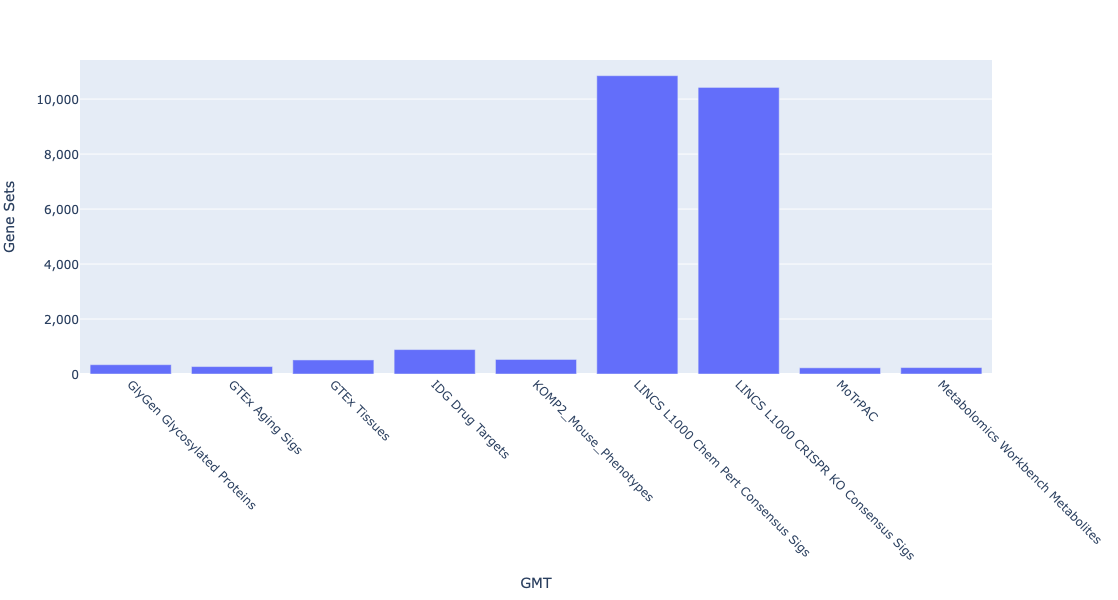

In [47]:
plot_genesets()

In [10]:
import math
dataframe_names = ['GlyGen_Glycosylated_Proteins', 
 'GTEx_Aging_Sigs', 
 'GTEx_Tissues', 
 'IDG_Drug_Targets', 
 'KOMP2_Mouse_Phenotypes', 
 'LINCS_L1000_Chem_Pert_Consensus_Sigs', 
 'LINCS_L1000_CRISPR_KO_Consensus_Sigs',
 'MoTrPAC', 
 'Metabolomics_Workbench_Metabolites']
import uuid

for lib in dataframe_names: 
    for inner_lib in dataframe_names:
        if not(lib == inner_lib):
            if not((lib == 'LINCS_L1000_Chem_Pert_Consensus_Sigs') or (lib == 'LINCS_L1000_CRISPR_KO_Consensus_Sigs')):
                if not((inner_lib == 'LINCS_L1000_Chem_Pert_Consensus_Sigs') or (inner_lib == 'LINCS_L1000_CRISPR_KO_Consensus_Sigs')):
                    try: 
                        crossed_dataframe = pd.read_csv('./crossed_sets/' + lib+ '_' + inner_lib + '_crossing_data.csv', index_col=0)
                        filtered_dataframe = crossed_dataframe[crossed_dataframe['P-value'] < 0.001]
                        for index, row in tqdm(filtered_dataframe.iterrows(), total=filtered_dataframe.shape[0]):
                            if row['Odds_Ratio'] == math.inf:
                                row['Odds_Ratio'] = 999999999999999.99
                            cur.execute('''INSERT INTO cfde_cross_pair (id, lib_1, lib_2, geneset_1, geneset_2, odds_ratio, pvalue, n_overlap, overlap) 
                                            VALUES  (%s, %s, %s, %s, %s, %s, %s, %s, %s);''', (str(uuid.uuid4()), row['Lib1'], row['Lib2'], row['Geneset_1'], row['Geneset_2'], row['Odds_Ratio'], row['P-value'], row['n_Overlap'], row['Overlap'].strip('][').split(', ')))
                            conn.commit()
                    except:
                        continue

# conn.commit()
conn.close()
cur.close()
## CLOSE CURSOR

  0%|          | 0/1453 [00:00<?, ?it/s]

100%|██████████| 192/192 [00:00<00:00, 6272.93it/s]
